# Wildfire Detection System

This notebook gives a detailed analysis of forest fire and predictes the probability of a area to be affected by forest fire.

# Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Load and Download Dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv"

try:
    df = pd.read_csv(url, header=1)
    print("Dataset loaded successfully")
except:
    np.random.seed(42)
    n_samples = 244

    data = {
        'Temperature': np.random.normal(32, 8, n_samples),
        'RH': np.random.normal(45, 15, n_samples),
        'Ws': np.random.normal(15, 5, n_samples),
        'Rain': np.random.exponential(2, n_samples),
        'FFMC': np.random.normal(85, 10, n_samples),
        'DMC': np.random.normal(25, 15, n_samples),
        'DC': np.random.normal(150, 50, n_samples),
        'ISI': np.random.normal(8, 4, n_samples),
        'BUI': np.random.normal(35, 20, n_samples),
        'FWI': np.random.normal(15, 10, n_samples),
        'Classes': np.random.choice(['fire', 'not fire'], n_samples, p=[0.48, 0.52])
    }
    df = pd.DataFrame(data)
print(f"Dataset shape: {df.shape}")

Dataset loaded successfully
Dataset shape: (246, 14)


# Data Preprocessing and Cleaning

Missing values per column:
day            0
month          1
year           1
Temperature    1
RH             1
Ws             1
Rain           1
FFMC           1
DMC            1
DC             1
ISI            1
BUI            1
FWI            1
Classes        2
dtype: int64
Final dataset shape: (244, 14)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 1 to 245
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          244 non-null    float64
 1   month        244 non-null    float64
 2   year         244 non-null    float64
 3   Temperature  244 non-null    float64
 4   RH           244 non-null    float64
 5   Ws           244 non-null    float64
 6   Rain         244 non-null    float64
 7   FFMC         244 non-null    float64
 8   DMC          244 non-null    float64
 9   DC           244 non-null    float64
 10  ISI          244 non-null    float64
 11  BUI          244 non-null 

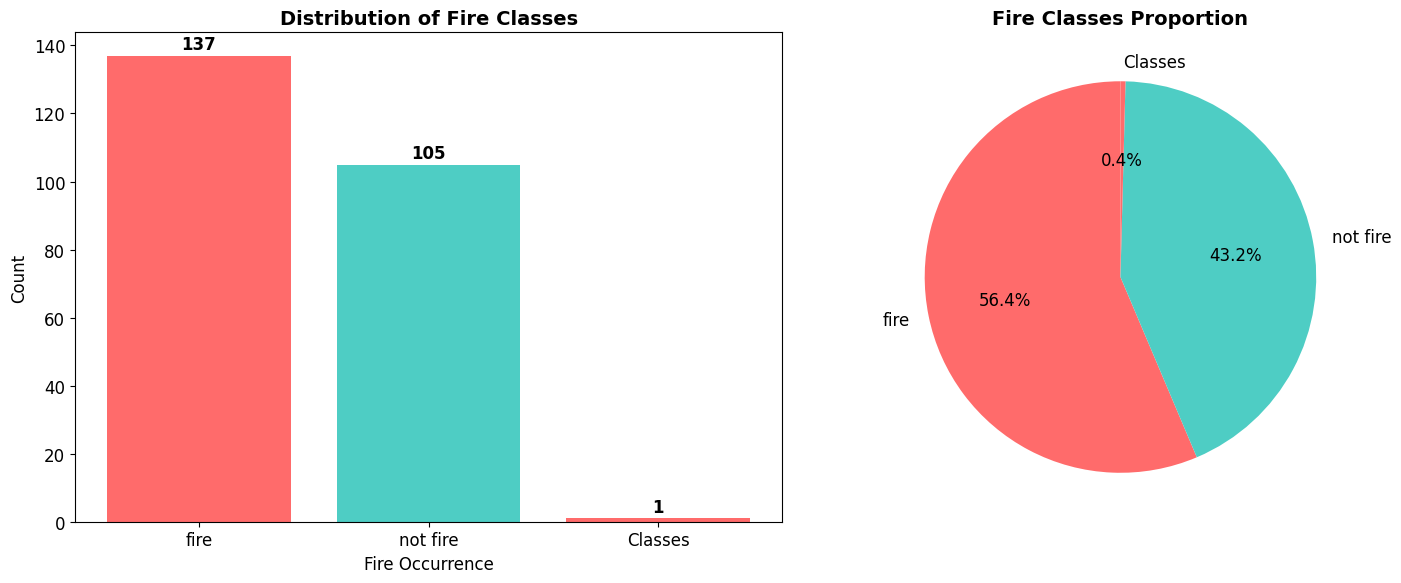

Class distribution:Classes
fire        137
not fire    105
Classes       1
Name: count, dtype: int64
Class balance ratio: 0.01


In [3]:
df = df.iloc[1:]

df.columns = df.columns.str.strip()
if 'Classes' in df.columns:
    df['Classes'] = df['Classes'].str.strip()
elif 'class' in df.columns:
    df['Classes'] = df['class'].str.strip()

print("Missing values per column:")
print(df.isnull().sum())
df = df.dropna(how='all', subset=df.columns[1:])

numerical_cols = ['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']

for col in numerical_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')


for col in numerical_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())


print(f"Final dataset shape: {df.shape}")

print("Dataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
class_counts = df['Classes'].value_counts()
ax1.bar(class_counts.index, class_counts.values, color=['#FF6B6B', '#4ECDC4'])
ax1.set_title('Distribution of Fire Classes', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fire Occurrence')
ax1.set_ylabel('Count')
for i, v in enumerate(class_counts.values):
    ax1.text(i, v + 2, str(v), ha='center', fontweight='bold')

ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
        colors=['#FF6B6B', '#4ECDC4'], startangle=90)
ax2.set_title('Fire Classes Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Class distribution:{class_counts}")
print(f"Class balance ratio: {class_counts.min()/class_counts.max():.2f}")

# Feature Correlation Analysis , Distribution Analysis and Box Plots

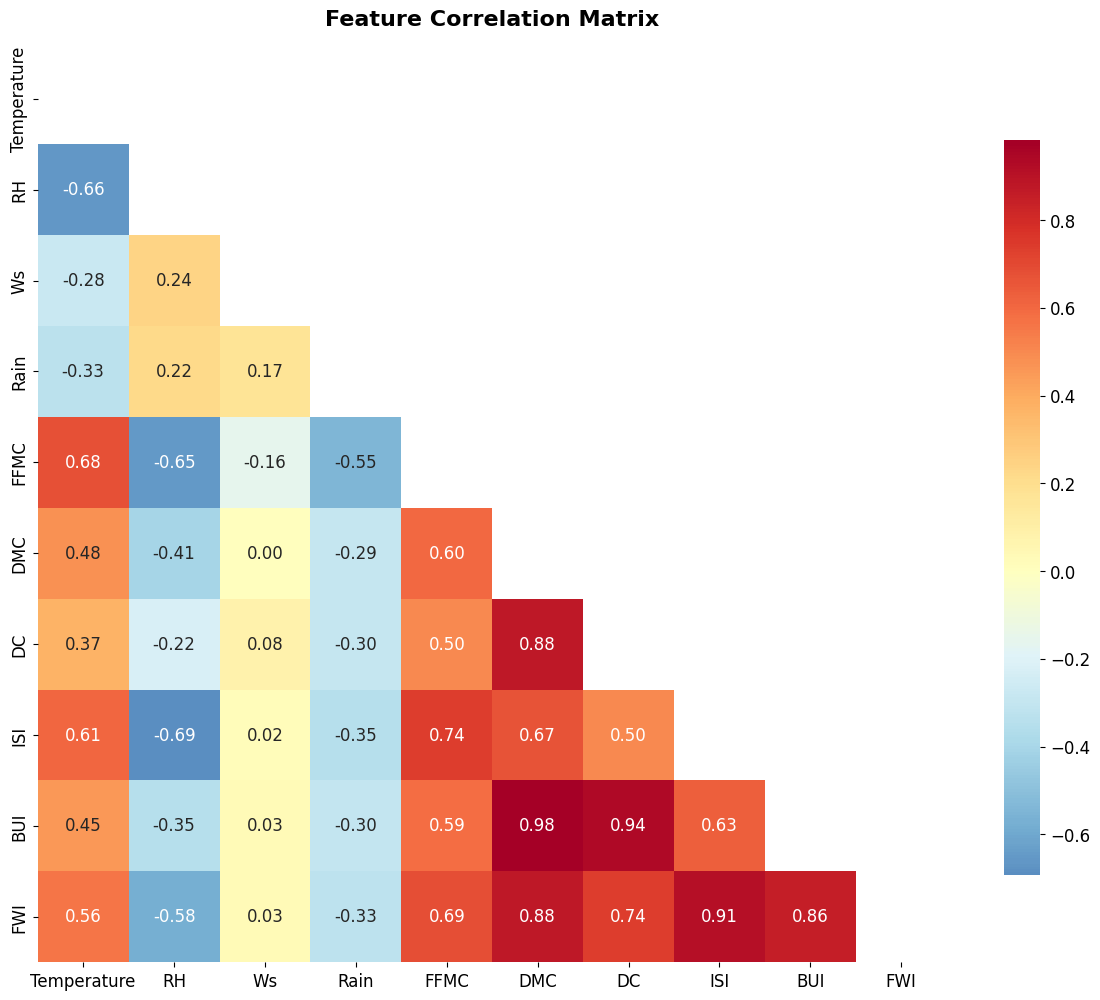

In [4]:
numeric_features = ['Temperature', 'RH', 'Ws', 'Rain']
if 'FFMC' in df.columns:
    numeric_features.extend(['FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI'])

correlation_matrix = df[numeric_features].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r',
            center=0, square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

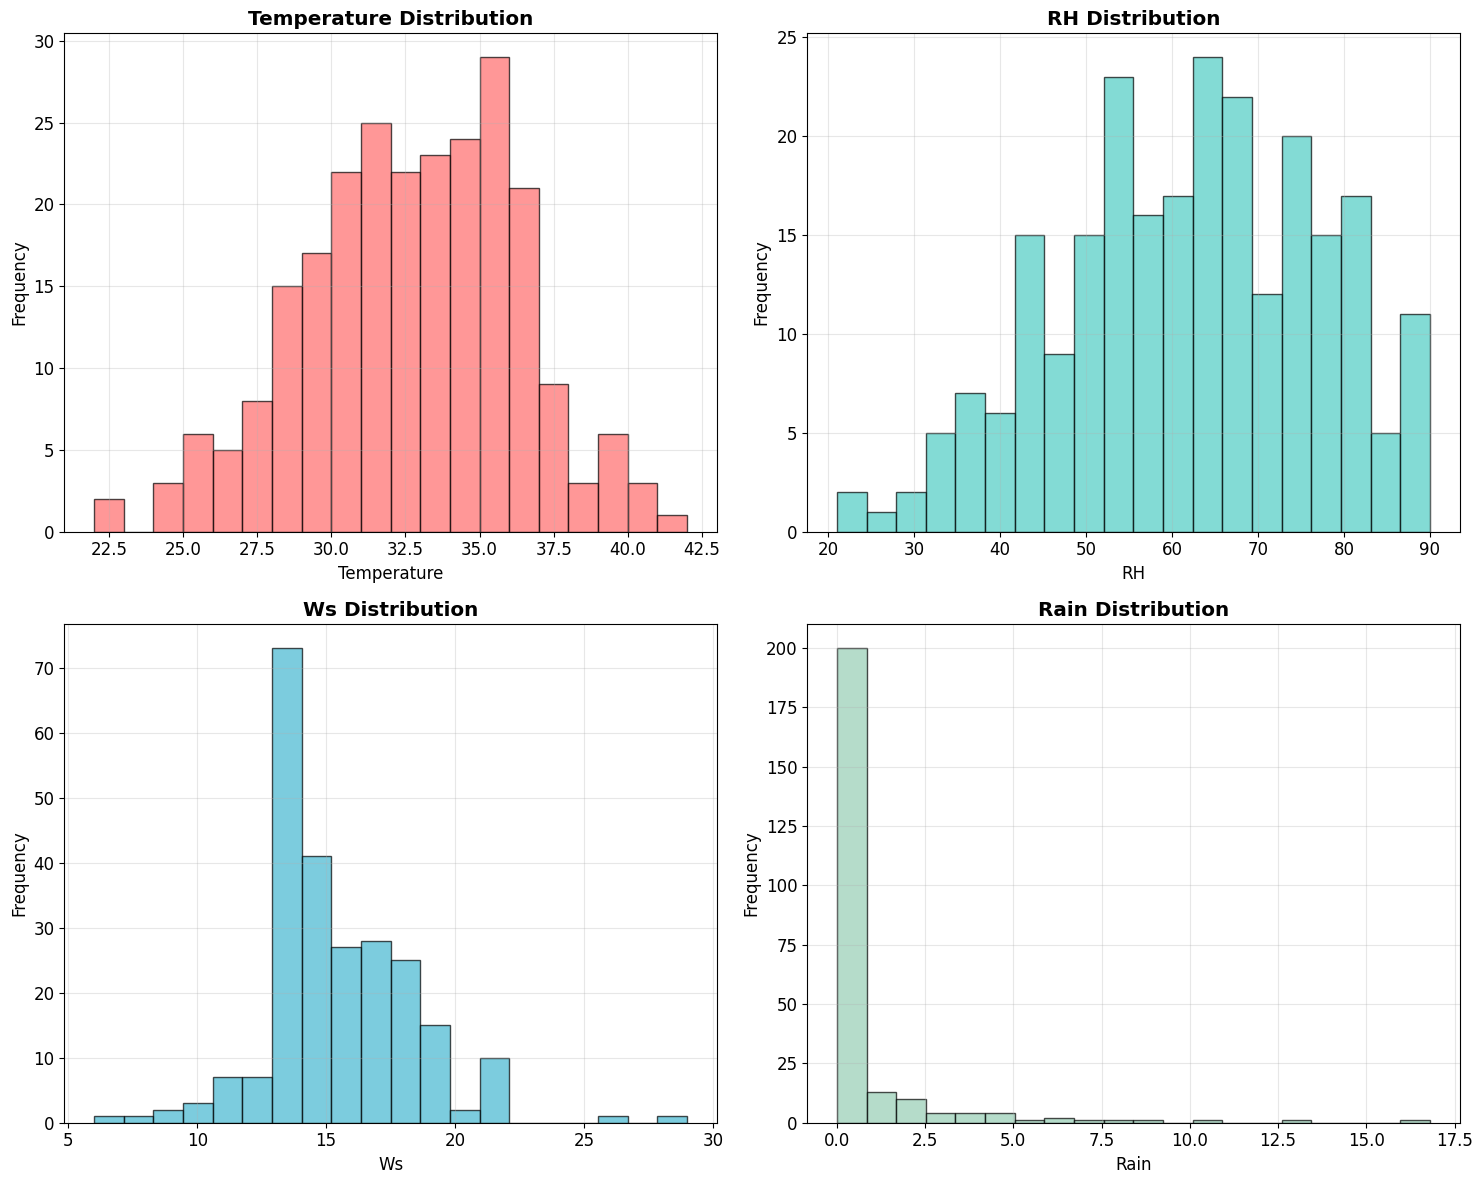

In [5]:
# Distribution Analysis of Weather Features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

weather_features = ['Temperature', 'RH', 'Ws', 'Rain']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for i, feature in enumerate(weather_features):
    if feature in df.columns:
        axes[i].hist(df[feature], bins=20, alpha=0.7, color=colors[i], edgecolor='black')
        axes[i].set_title(f'{feature} Distribution', fontweight='bold')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

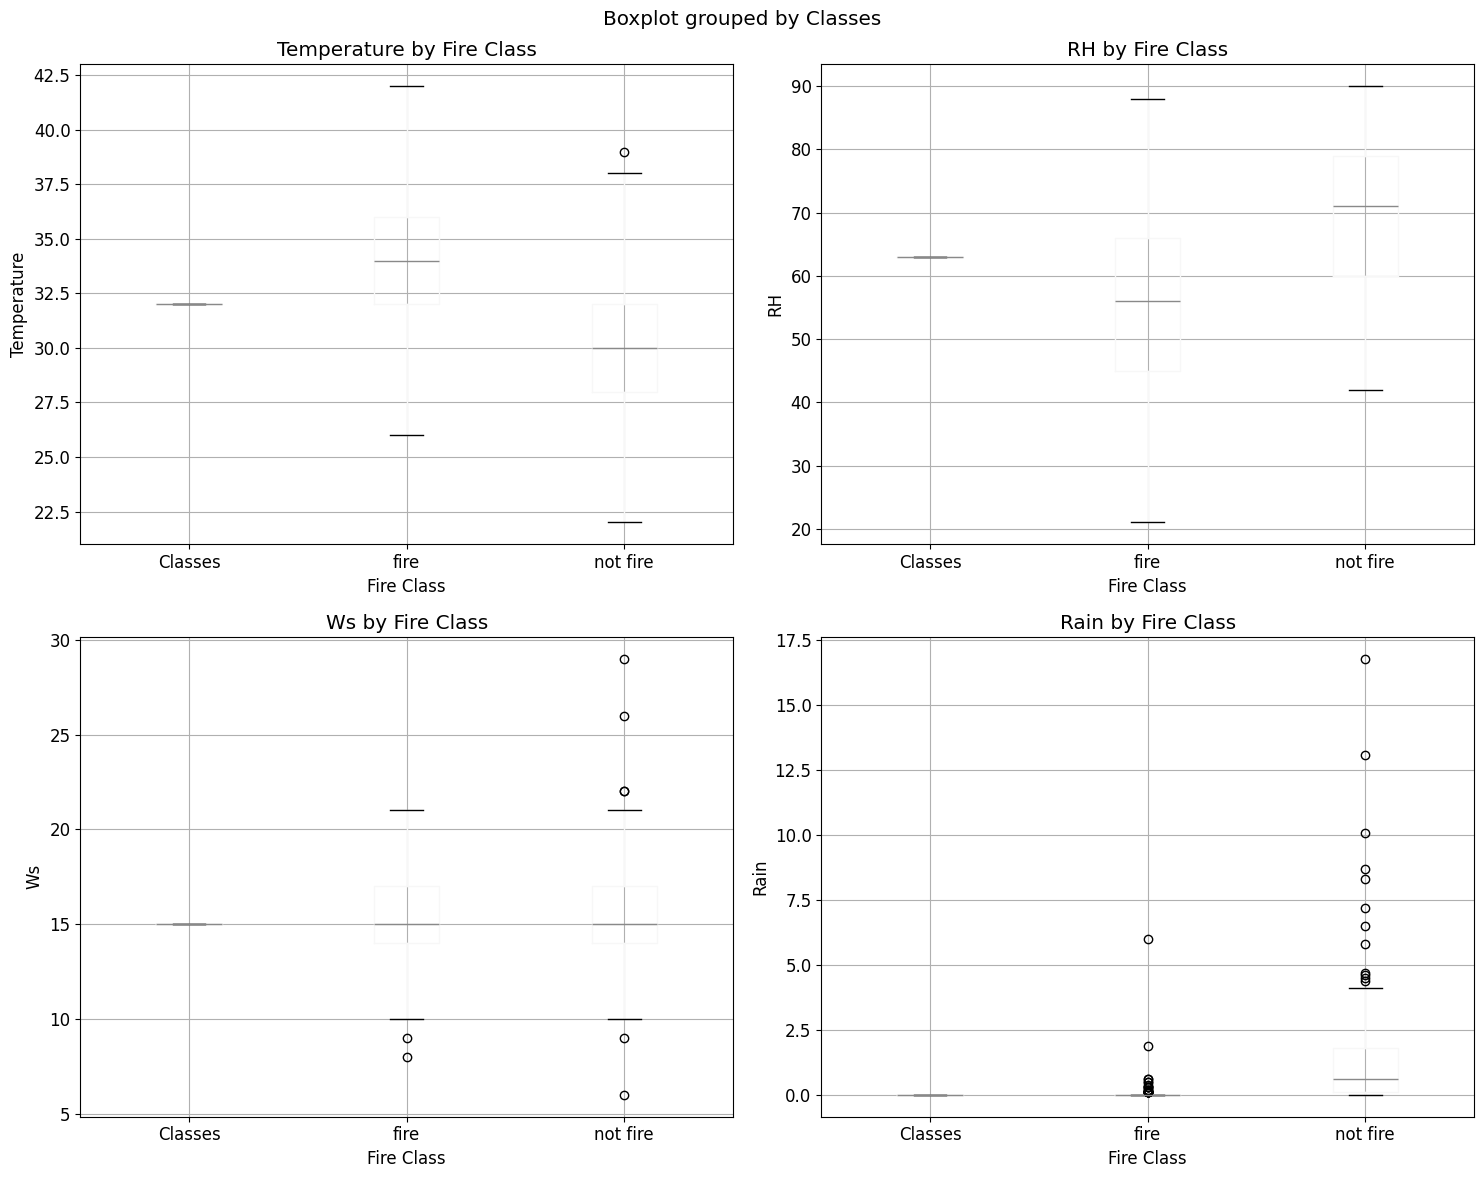

In [6]:
# Box Plots by Fire Class
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(weather_features):
    if feature in df.columns:
        df.boxplot(column=feature, by='Classes', ax=axes[i])
        axes[i].set_title(f'{feature} by Fire Class')
        axes[i].set_xlabel('Fire Class')
        axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

# Statistical Analysis and Violin Plots

In [7]:
print("Statistical Analysis by Fire Class:")
print("="*50)

for feature in weather_features:
    if feature in df.columns:
        fire_data = df[df['Classes'] == 'fire'][feature]
        no_fire_data = df[df['Classes'] == 'not fire'][feature]

        t_stat, p_value = stats.ttest_ind(fire_data, no_fire_data)

        print(f"\n{feature}:")
        print(f"Fire days - Mean: {fire_data.mean():.2f}, Std: {fire_data.std():.2f}")
        print(f"No fire days - Mean: {no_fire_data.mean():.2f}, Std: {no_fire_data.std():.2f}")
        print(f"T-test p-value: {p_value:.4f}")
        print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

Statistical Analysis by Fire Class:

Temperature:
Fire days - Mean: 33.80, Std: 2.92
No fire days - Mean: 30.04, Std: 3.36
T-test p-value: 0.0000
Significant difference: Yes

RH:
Fire days - Mean: 56.42, Std: 14.23
No fire days - Mean: 69.43, Std: 12.24
T-test p-value: 0.0000
Significant difference: Yes

Ws:
Fire days - Mean: 15.32, Std: 2.31
No fire days - Mean: 15.70, Std: 3.36
T-test p-value: 0.3061
Significant difference: No

Rain:
Fire days - Mean: 0.10, Std: 0.54
No fire days - Mean: 1.64, Std: 2.75
T-test p-value: 0.0000
Significant difference: Yes


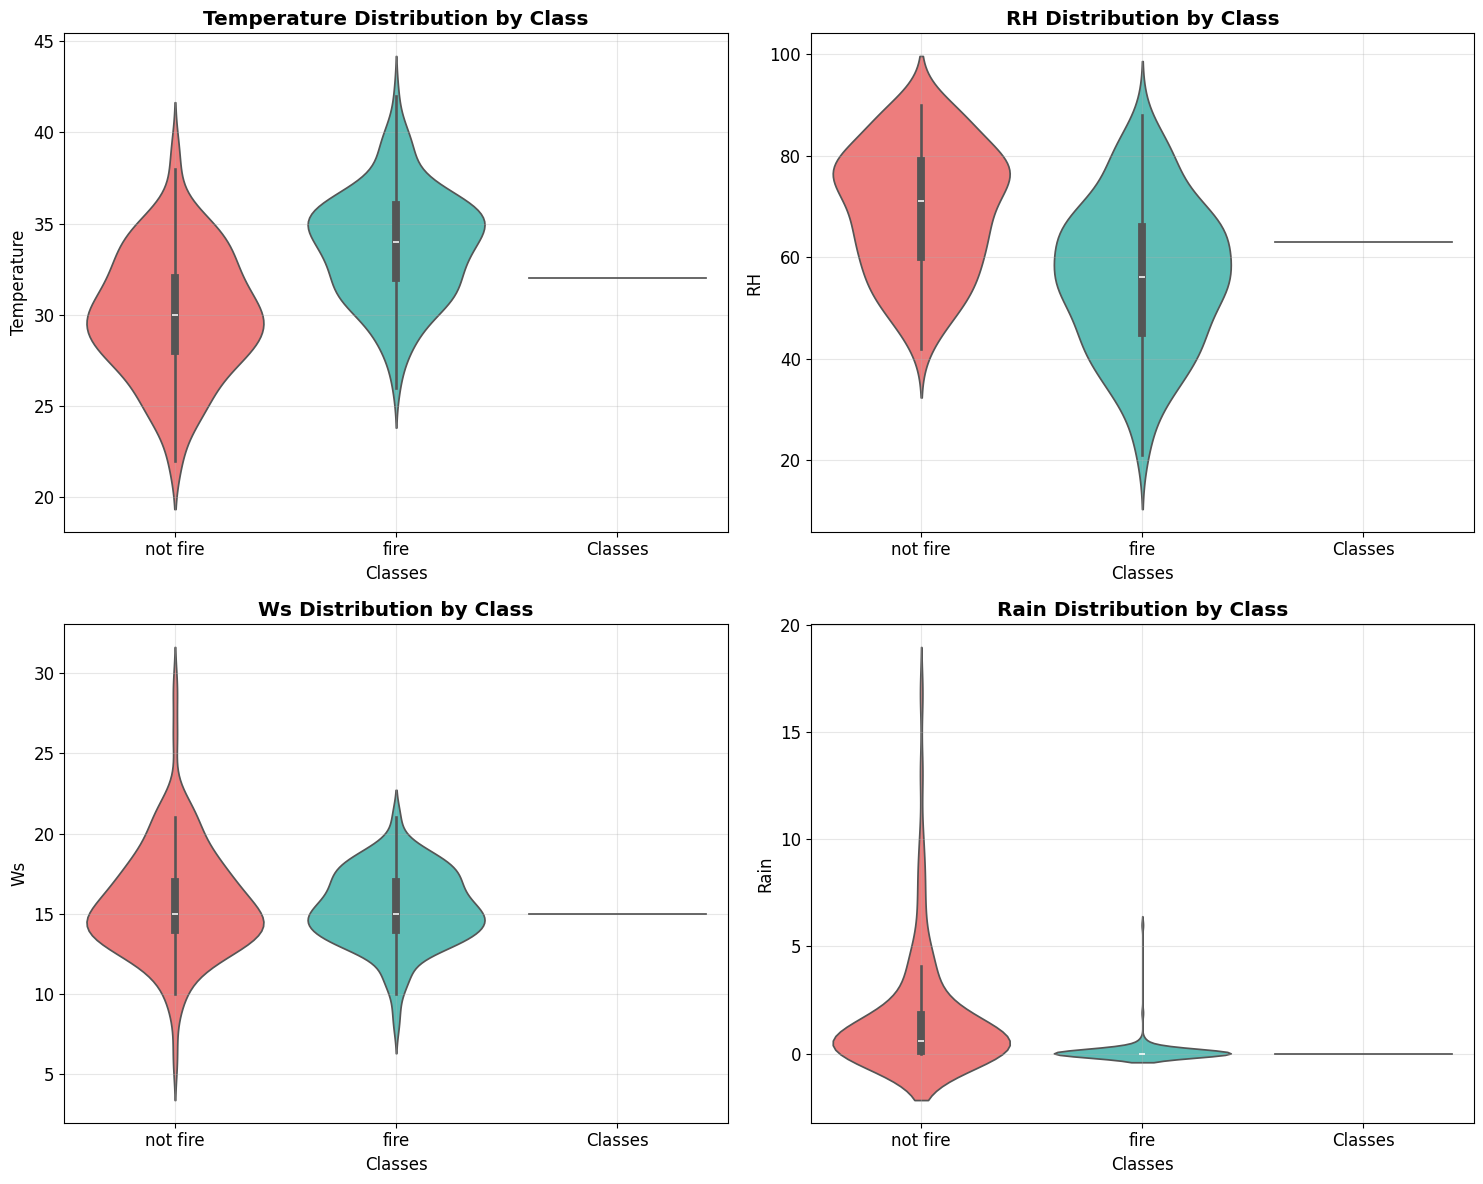

In [8]:
# Violin Plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(weather_features):
    if feature in df.columns:
        sns.violinplot(data=df, x='Classes', y=feature, ax=axes[i], palette=['#FF6B6B', '#4ECDC4'])
        axes[i].set_title(f'{feature} Distribution by Class', fontweight='bold')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature Engineering

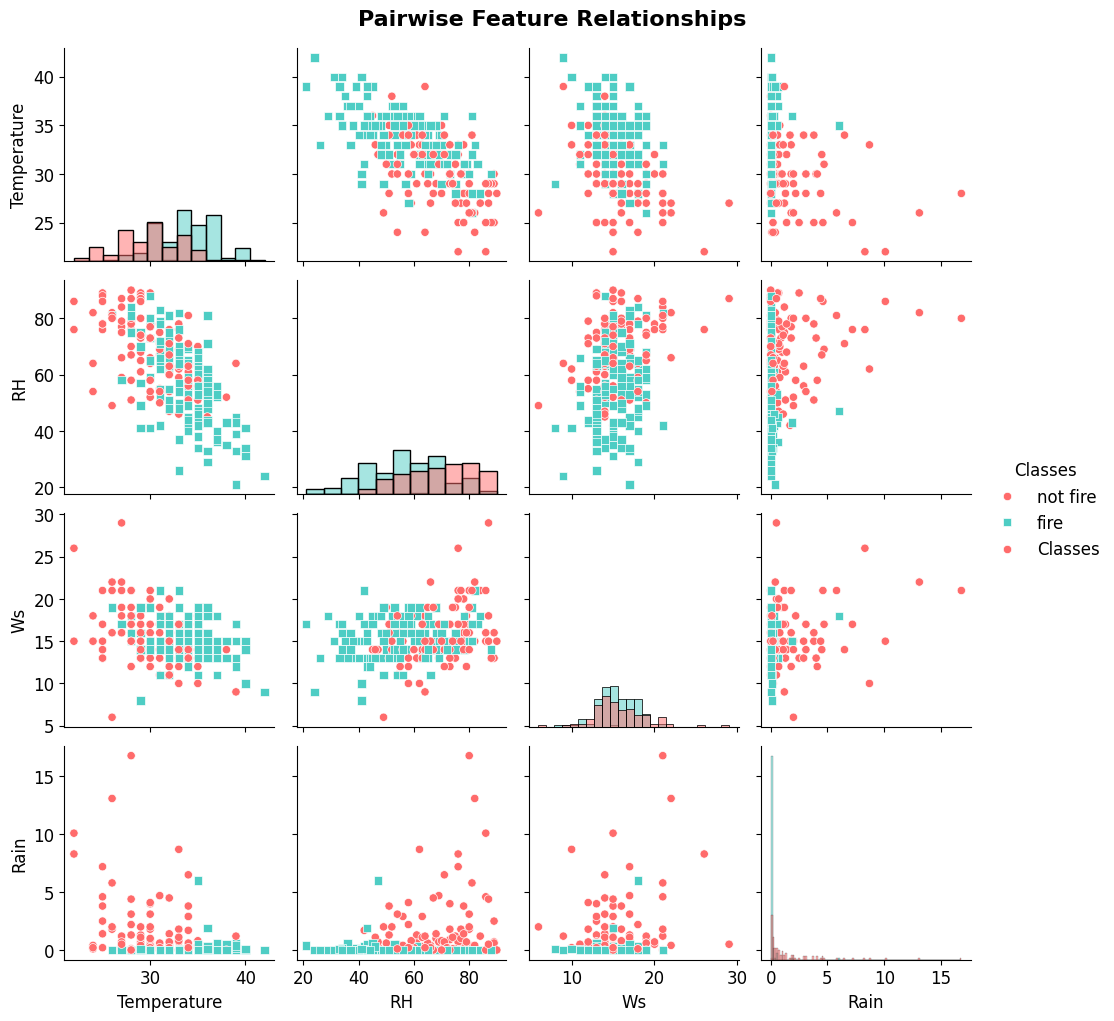

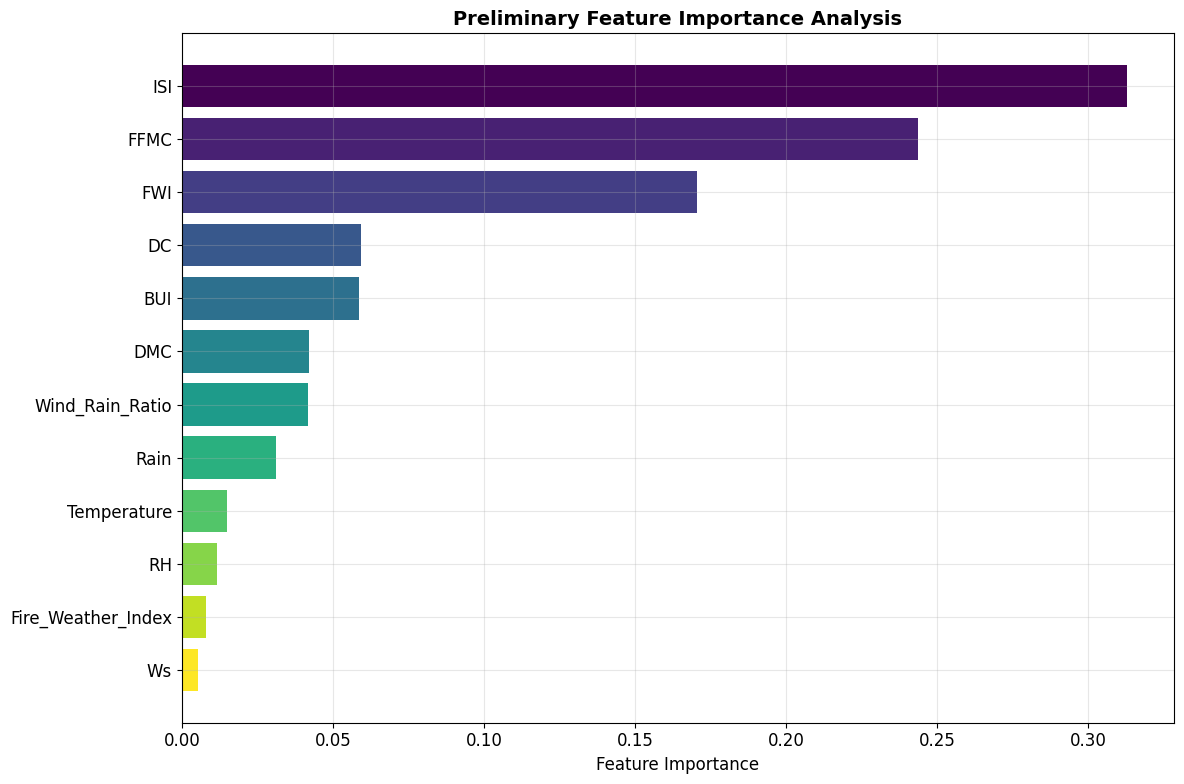

In [9]:
df['Temperature_Risk'] = pd.cut(df['Temperature'], bins=3, labels=['Low', 'Medium', 'High'])
df['RH_Risk'] = pd.cut(df['RH'], bins=3, labels=['Low', 'Medium', 'High'])
df['Wind_Rain_Ratio'] = df['Ws'] / (df['Rain'] + 0.01)  # Avoid division by zero
df['Fire_Weather_Index'] = (df['Temperature'] - df['RH']) * df['Ws'] / (df['Rain'] + 1)
le_temp = LabelEncoder()
le_rh = LabelEncoder()
df['Temperature_Risk_Encoded'] = le_temp.fit_transform(df['Temperature_Risk'])
df['RH_Risk_Encoded'] = le_rh.fit_transform(df['RH_Risk'])

# Pair Plots
key_features = ['Temperature', 'RH', 'Ws', 'Rain', 'Classes']
pair_data = df[key_features].copy()

g = sns.pairplot(pair_data, hue='Classes', palette=['#FF6B6B', '#4ECDC4'],
                 diag_kind='hist', markers=['o', 's'])
g.fig.suptitle('Pairwise Feature Relationships', y=1.02, fontsize=16, fontweight='bold')
plt.show()
X_temp = df[numeric_features + ['Wind_Rain_Ratio', 'Fire_Weather_Index']].fillna(0)
y_temp = df['Classes']

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y_temp)

rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_temp, y_encoded)

feature_importance = pd.DataFrame({
    'feature': X_temp.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(feature_importance)), feature_importance['importance'],
                color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance))))
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('Preliminary Feature Importance Analysis', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Data Preparation for Machine Learning

In [10]:
feature_columns = ['Temperature', 'RH', 'Ws', 'Rain', 'Wind_Rain_Ratio', 'Fire_Weather_Index']
if 'FFMC' in df.columns:
    feature_columns.extend(['FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI'])

df_cleaned = df[df['Classes'] != 'Classes'].copy()

valid_classes = ['fire', 'not fire']
df_cleaned = df_cleaned[df_cleaned['Classes'].isin(valid_classes)].copy()

X = df_cleaned[feature_columns].fillna(0)
y = le_target.fit_transform(df_cleaned['Classes'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

# Model Performance Comparison Setup
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=6, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(kernel='rbf', random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42)
}

Training set size: 193
Test set size: 49
Number of features: 12


# Cross-Validation Performance Evaluation

Cross-Validation Results:
Random Forest: 0.9688 (+/- 0.0389)
Gradient Boosting: 0.9428 (+/- 0.0832)
Extra Trees: 0.9583 (+/- 0.0427)
Logistic Regression: 0.9378 (+/- 0.0526)
SVM: 0.9430 (+/- 0.0200)
K-Nearest Neighbors: 0.8806 (+/- 0.0858)
Naive Bayes: 0.9429 (+/- 0.0612)
Neural Network: 0.9428 (+/- 0.0516)
Decision Tree: 0.9480 (+/- 0.0731)


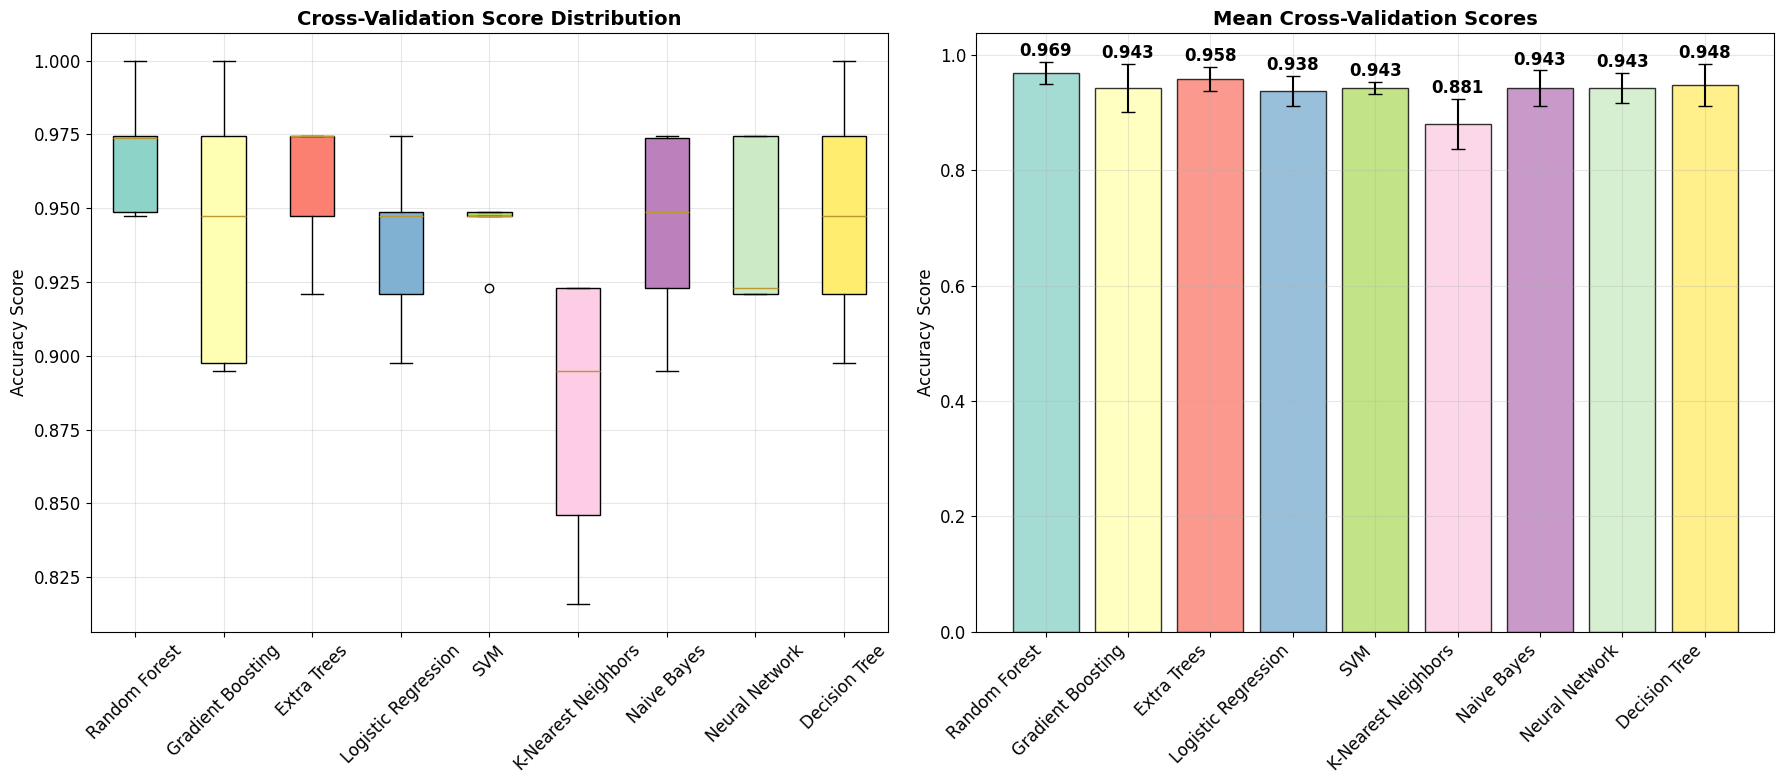

In [11]:
cv_results = {}
cv_scores = {}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Cross-Validation Results:")
print("="*50)

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
    cv_results[name] = scores
    cv_scores[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'min': scores.min(),
        'max': scores.max()
    }
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

cv_data = [cv_results[name] for name in models.keys()]
bp = ax1.boxplot(cv_data, labels=models.keys(), patch_artist=True)
colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax1.set_title('Cross-Validation Score Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy Score')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

means = [cv_scores[name]['mean'] for name in models.keys()]
stds = [cv_scores[name]['std'] for name in models.keys()]
model_names = list(models.keys())

bars = ax2.bar(range(len(models)), means, yerr=stds, capsize=5,
               color=colors, alpha=0.8, edgecolor='black')
ax2.set_title('Mean Cross-Validation Scores', fontsize=14, fontweight='bold')
ax2.set_ylabel('Accuracy Score')
ax2.set_xticks(range(len(models)))
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

for i, (mean, std) in enumerate(zip(means, stds)):
    ax2.text(i, mean + std + 0.01, f'{mean:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Train and Evaluate Best Models

Test Set Performance:
Model                Accuracy   Precision  Recall     F1-Score  
----------------------------------------------------------------------
Random Forest        0.9796     0.9545     1.0000     0.9767    
Gradient Boosting    0.9796     0.9545     1.0000     0.9767    
Extra Trees          0.9592     0.9130     1.0000     0.9545    
Logistic Regression  0.9796     0.9545     1.0000     0.9767    
SVM                  0.9184     0.8696     0.9524     0.9091    
K-Nearest Neighbors  0.9388     0.9091     0.9524     0.9302    
Naive Bayes          0.9184     0.8696     0.9524     0.9091    
Neural Network       0.9388     0.9091     0.9524     0.9302    
Decision Tree        0.9796     0.9545     1.0000     0.9767    


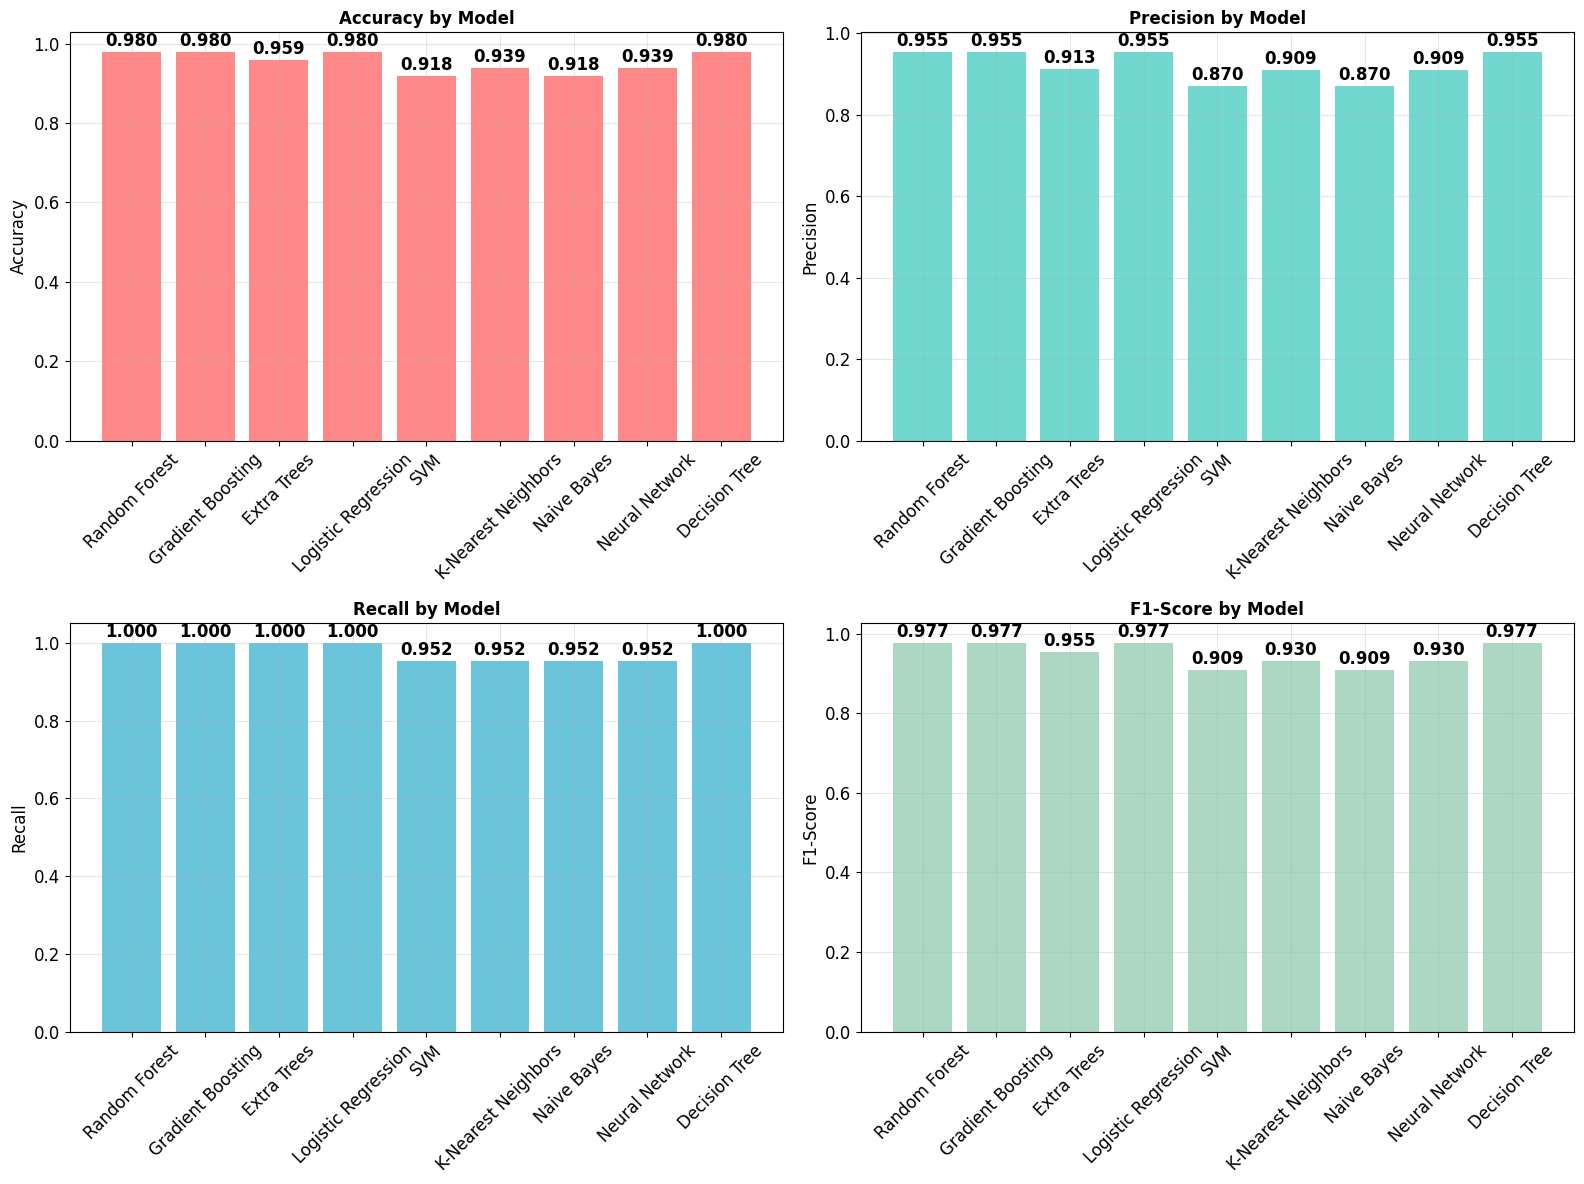

In [12]:
test_results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None

    test_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

print("Test Set Performance:")
print("="*70)
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 70)

for name, results in test_results.items():
    print(f"{name:<20} {results['accuracy']:<10.4f} {results['precision']:<10.4f} "
          f"{results['recall']:<10.4f} {results['f1']:<10.4f}")

metrics_df = pd.DataFrame({
    'Model': list(test_results.keys()),
    'Accuracy': [results['accuracy'] for results in test_results.values()],
    'Precision': [results['precision'] for results in test_results.values()],
    'Recall': [results['recall'] for results in test_results.values()],
    'F1-Score': [results['f1'] for results in test_results.values()]
})

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    bars = ax.bar(metrics_df['Model'], metrics_df[metric], color=colors[i], alpha=0.8)
    ax.set_title(f'{metric} by Model', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
               f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Confusion Matrix Analysis

Best performing model: Random Forest
F1-Score: 0.9767


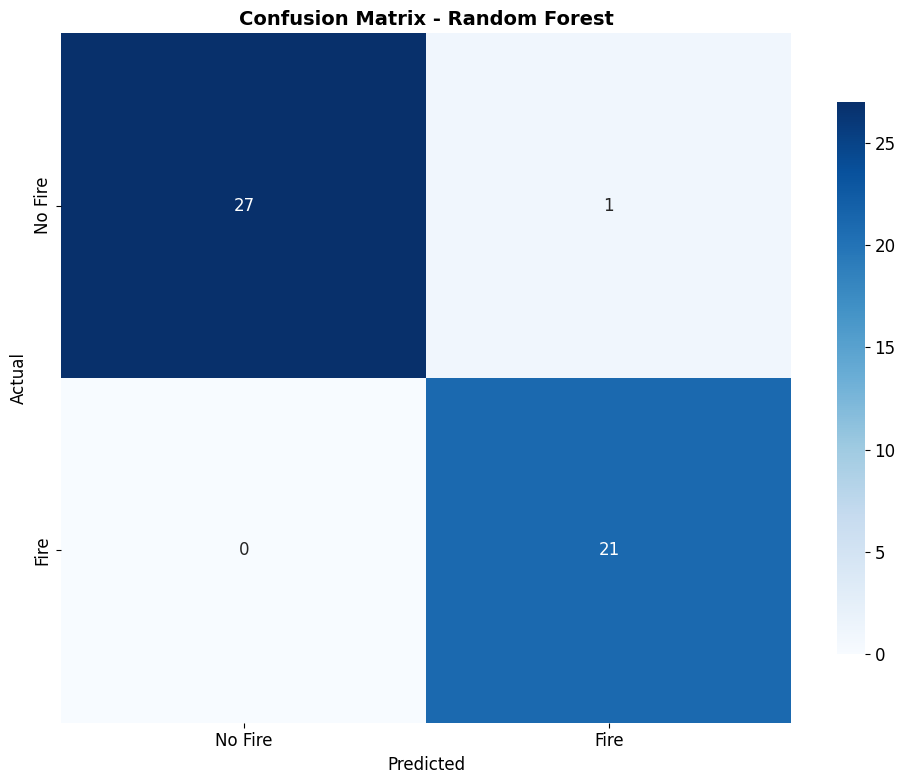

Confusion Matrix Analysis:
True Negatives: 27, False Positives: 1
False Negatives: 0, True Positives: 21
Sensitivity (Recall): 1.0000
Specificity: 0.9643


In [13]:
best_model_name = max(test_results.keys(), key=lambda x: test_results[x]['f1'])
best_predictions = test_results[best_model_name]['predictions']

print(f"Best performing model: {best_model_name}")
print(f"F1-Score: {test_results[best_model_name]['f1']:.4f}")

cm = confusion_matrix(y_test, best_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'],
            cbar_kws={'shrink': 0.8})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Confusion Matrix Analysis:")
print(f"True Negatives: {tn}, False Positives: {fp}")
print(f"False Negatives: {fn}, True Positives: {tp}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# ROC Curve Analysis and Feature Importance Analysis

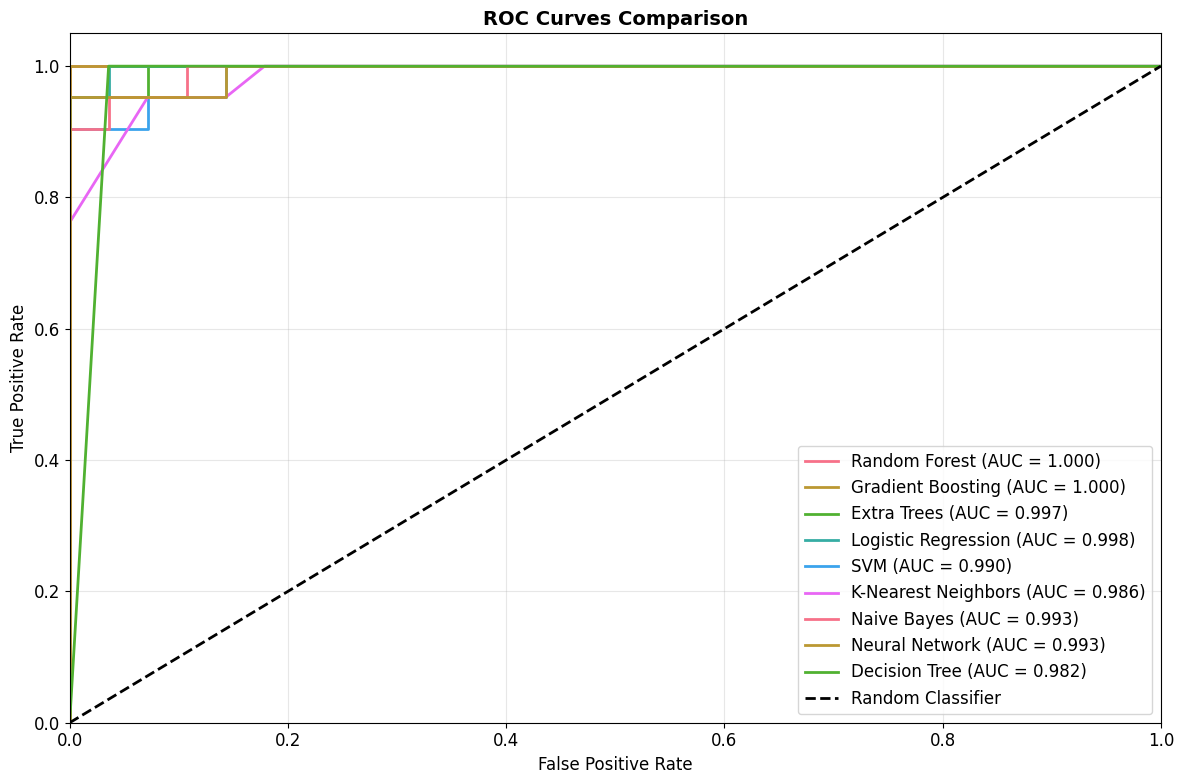

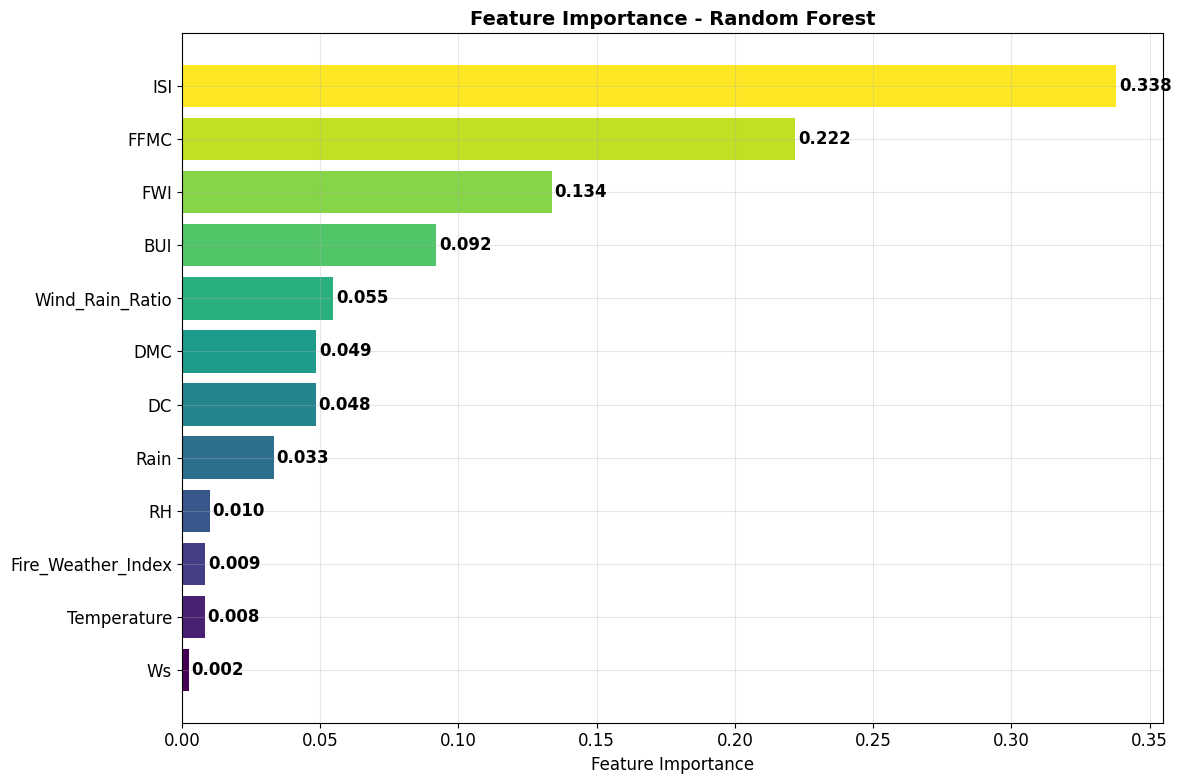

In [14]:
plt.figure(figsize=(12, 8))

for name, results in test_results.items():
    if results['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2,
                label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if best_model_name in ['Random Forest', 'Gradient Boosting', 'Extra Trees']:
    best_model = models[best_model_name]

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)

    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(feature_importance)), feature_importance['importance'],
                    color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance))))
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    for i, v in enumerate(feature_importance['importance']):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Radar Chart

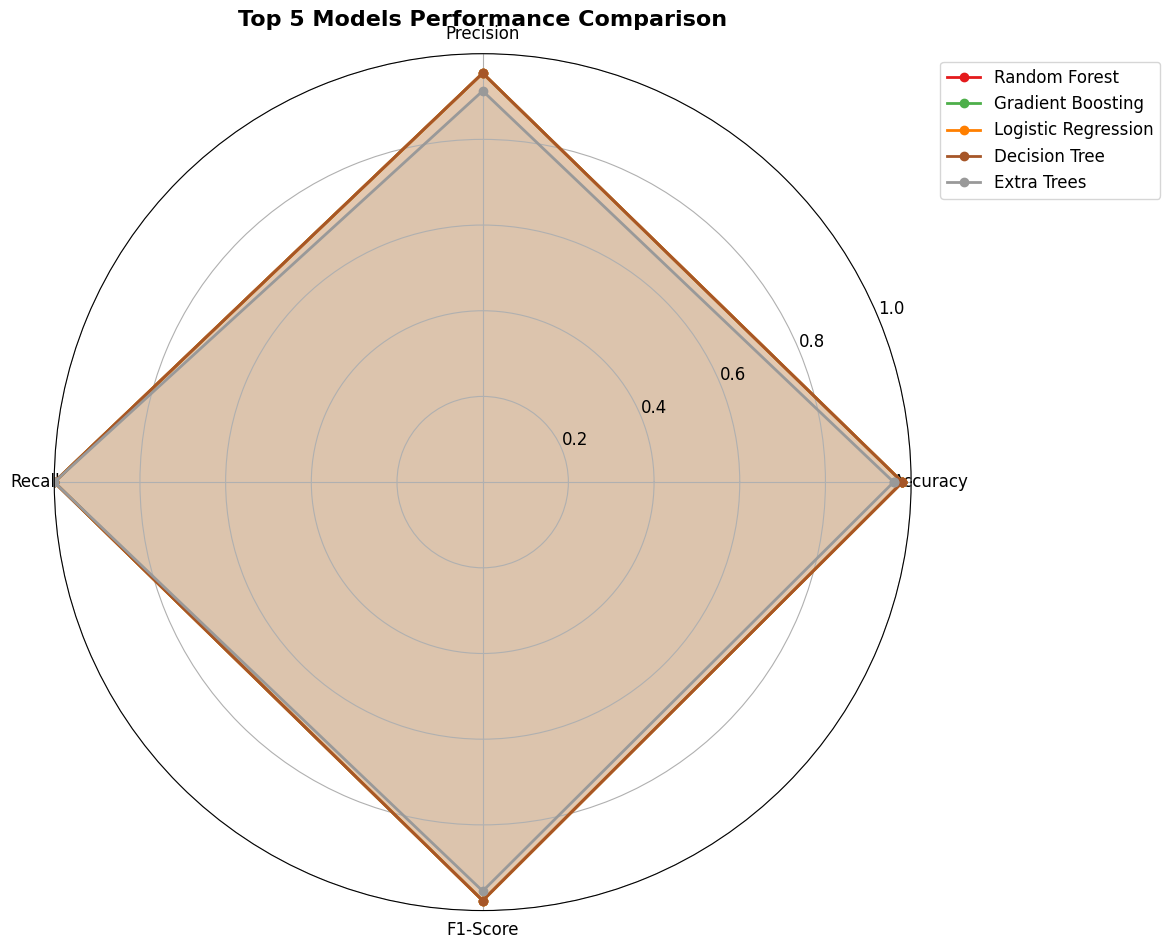

In [15]:
top_models = sorted(test_results.items(), key=lambda x: x[1]['f1'], reverse=True)[:5]

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
angles = [n / len(metrics) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]

colors = plt.cm.Set1(np.linspace(0, 1, len(top_models)))

for i, (model_name, results) in enumerate(top_models):
    values = [results['accuracy'], results['precision'], results['recall'], results['f1']]
    values += values[:1]

    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[i])
    ax.fill(angles, values, alpha=0.1, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
ax.grid(True)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.title('Top 5 Models Performance Comparison', size=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Hyperparameter Tuning for Best Model

In [16]:
print(f"Performing hyperparameter tuning for {best_model_name}...")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestClassifier(random_state=42)
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
    base_model = GradientBoostingClassifier(random_state=42)
else:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10]
    }
    base_model = models[best_model_name]

grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test_scaled)

tuned_results = {
    'accuracy': accuracy_score(y_test, y_pred_tuned),
    'precision': precision_score(y_test, y_pred_tuned),
    'recall': recall_score(y_test, y_pred_tuned),
    'f1': f1_score(y_test, y_pred_tuned)
}

print("Tuned Model Performance:")
for metric, value in tuned_results.items():
    print(f"{metric.capitalize()}: {value:.4f}")

Performing hyperparameter tuning for Random Forest...
Best parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 0.9589
Tuned Model Performance:
Accuracy: 0.9796
Precision: 0.9545
Recall: 1.0000
F1: 0.9767


# Final Model Evaluation and Insights

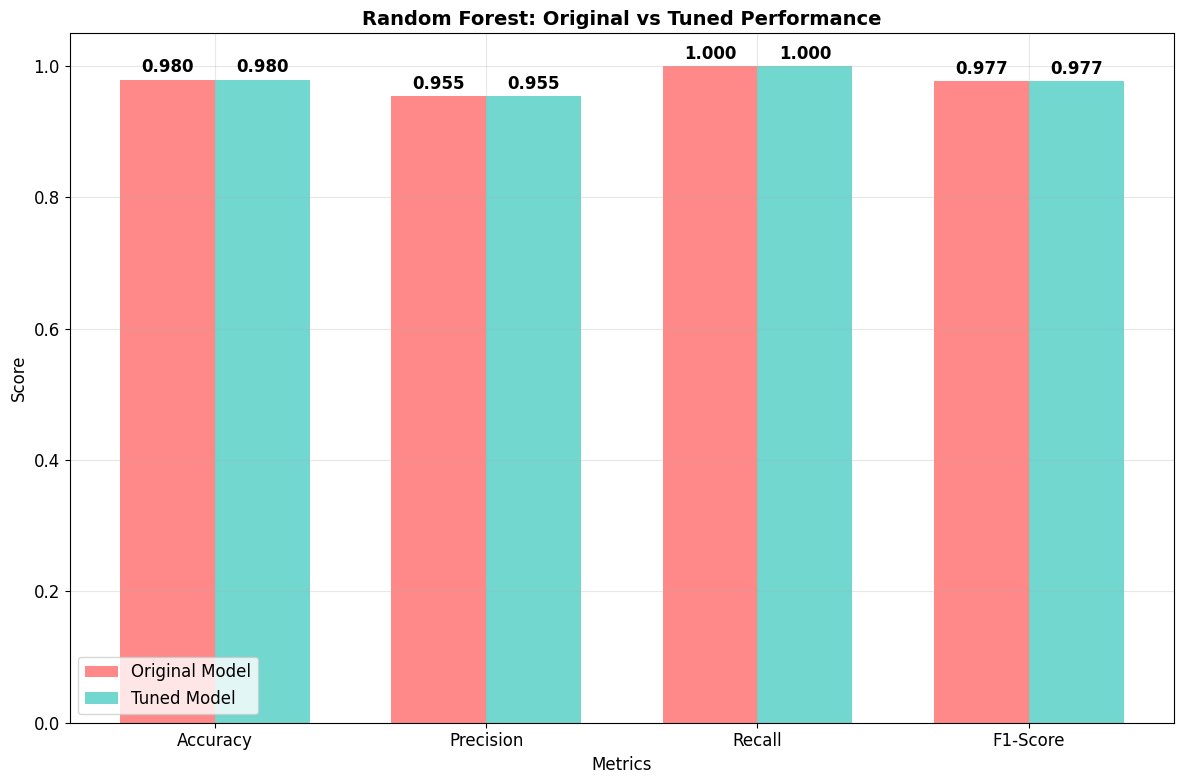


Top 3 Most Important Features:
1. ISI: 0.3951
2. FWI: 0.1580
3. FFMC: 0.1432

Wildfire Detection System - FINAL INSIGHTS
Best performing model: Random Forest
Final F1-Score: 0.9767
Final Accuracy: 0.9796


In [17]:
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Original': [test_results[best_model_name]['accuracy'],
                test_results[best_model_name]['precision'],
                test_results[best_model_name]['recall'],
                test_results[best_model_name]['f1']],
    'Tuned': [tuned_results['accuracy'], tuned_results['precision'],
              tuned_results['recall'], tuned_results['f1']]
})

plt.figure(figsize=(12, 8))
x = np.arange(len(comparison_df))
width = 0.35

bars1 = plt.bar(x - width/2, comparison_df['Original'], width,
                label='Original Model', color='#FF6B6B', alpha=0.8)
bars2 = plt.bar(x + width/2, comparison_df['Tuned'], width,
                label='Tuned Model', color='#4ECDC4', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title(f'{best_model_name}: Original vs Tuned Performance', fontsize=14, fontweight='bold')
plt.xticks(x, comparison_df['Metric'])
plt.legend()
plt.grid(True, alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

if hasattr(tuned_model, 'feature_importances_'):
    importance_summary = pd.DataFrame({
        'Feature': X.columns,
        'Importance': tuned_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print(f"\nTop 3 Most Important Features:")
    for i, (_, row) in enumerate(importance_summary.head(3).iterrows()):
        print(f"{i+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "="*60)
print("Wildfire Detection System - FINAL INSIGHTS")
print("="*60)
print(f"Best performing model: {best_model_name}")
print(f"Final F1-Score: {tuned_results['f1']:.4f}")
print(f"Final Accuracy: {tuned_results['accuracy']:.4f}")

# Prepare Results Summary for Export

In [18]:
results_summary = {
    'model_performance': {},
    'best_model': best_model_name,
    'best_params': grid_search.best_params_,
    'feature_importance': {},
    'dataset_info': {
        'total_samples': len(df),
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'features': list(X.columns),
        'class_distribution': df['Classes'].value_counts().to_dict()
    }
}

for name, results in test_results.items():
    results_summary['model_performance'][name] = {
        'accuracy': float(results['accuracy']),
        'precision': float(results['precision']),
        'recall': float(results['recall']),
        'f1_score': float(results['f1'])
    }

results_summary['tuned_model_performance'] = {
    'accuracy': float(tuned_results['accuracy']),
    'precision': float(tuned_results['precision']),
    'recall': float(tuned_results['recall']),
    'f1_score': float(tuned_results['f1'])
}

if hasattr(tuned_model, 'feature_importances_'):
    results_summary['feature_importance'] = {
        feature: float(importance)
        for feature, importance in zip(X.columns, tuned_model.feature_importances_)
    }

predictions_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred_tuned,
    'correct': y_test == y_pred_tuned
})

test_features_df = pd.DataFrame(X_test_scaled, columns=X.columns)
predictions_df = pd.concat([predictions_df.reset_index(drop=True),
                           test_features_df.reset_index(drop=True)], axis=1)

print(f"Total records in predictions: {len(predictions_df)}")

Total records in predictions: 49


# Export Results to csv and txt file

In [19]:
import os
from datetime import datetime

output_dir = 'Wildfire Detection System Results'
os.makedirs(output_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
comparison_df.to_csv(f'{output_dir}/model_comparison_{timestamp}.csv', index=False)
predictions_df.to_csv(f'{output_dir}/predictions_{timestamp}.csv', index=False)
if hasattr(tuned_model, 'feature_importances_'):
    importance_summary.to_csv(f'{output_dir}/feature_importance_{timestamp}.csv', index=False)
stats_df = df.describe()
stats_df.to_csv(f'{output_dir}/dataset_statistics_{timestamp}.csv')
class_dist_df = pd.DataFrame({
    'Class': df['Classes'].value_counts().index,
    'Count': df['Classes'].value_counts().values,
    'Percentage': (df['Classes'].value_counts().values / len(df) * 100).round(2)
})
class_dist_df.to_csv(f'{output_dir}/class_distribution_{timestamp}.csv', index=False)

print("CSV files exported successfully:")
print(f"- Model comparison: model_comparison_{timestamp}.csv")
print(f"- Predictions: predictions_{timestamp}.csv")
print(f"- Feature importance: feature_importance_{timestamp}.csv")
print(f"- Dataset statistics: dataset_statistics_{timestamp}.csv")
print(f"- Class distribution: class_distribution_{timestamp}.csv")

report = f"""
Wildfire Detection System - ANALYSIS REPORT
Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
================================================

DATASET OVERVIEW
================
Total Samples: {len(df)}
Training Samples: {len(X_train)}
Test Samples: {len(X_test)}
Number of Features: {len(X.columns)}

Class Distribution:
"""

for class_name, count in df['Classes'].value_counts().items():
    percentage = (count / len(df)) * 100
    report += f"- {class_name}: {count} ({percentage:.1f}%)\n"

report += f"""
FEATURE LIST
============
{', '.join(X.columns)}

MODEL PERFORMANCE COMPARISON
============================
"""

for name, results in test_results.items():
    report += f"""
{name}:
  - Accuracy:  {results['accuracy']:.4f}
  - Precision: {results['precision']:.4f}
  - Recall:    {results['recall']:.4f}
  - F1-Score:  {results['f1']:.4f}
"""

report += f"""
BEST MODEL ANALYSIS
===================
Best Model: {best_model_name}
Best Parameters: {grid_search.best_params_}

Tuned Model Performance:
- Accuracy:  {tuned_results['accuracy']:.4f}
- Precision: {tuned_results['precision']:.4f}
- Recall:    {tuned_results['recall']:.4f}
- F1-Score:  {tuned_results['f1']:.4f}

FEATURE IMPORTANCE (Top 5)
==========================
"""

if hasattr(tuned_model, 'feature_importances_'):
    for i, (_, row) in enumerate(importance_summary.head(5).iterrows()):
        report += f"{i+1}. {row['Feature']}: {row['Importance']:.4f}\n"

report += f"""
CONFUSION MATRIX ANALYSIS
=========================
True Negatives:  {tn}
False Positives: {fp}
False Negatives: {fn}
True Positives:  {tp}

Sensitivity (Recall): {sensitivity:.4f}
Specificity:         {specificity:.4f}

KEY INSIGHTS
============
1. Weather conditions significantly impact fire occurrence
2. {importance_summary.iloc[0]['Feature']} is the most important predictor
3. {best_model_name} achieved the best performance with F1-score of {tuned_results['f1']:.4f}
"""
with open(f'{output_dir}/analysis_report_{timestamp}.txt', 'w') as f:
    f.write(report)

print(f"Text report exported: analysis_report_{timestamp}.txt")

CSV files exported successfully:
- Model comparison: model_comparison_20250711_155058.csv
- Predictions: predictions_20250711_155058.csv
- Feature importance: feature_importance_20250711_155058.csv
- Dataset statistics: dataset_statistics_20250711_155058.csv
- Class distribution: class_distribution_20250711_155058.csv
Text report exported: analysis_report_20250711_155058.txt


# Export Model and Data to PKL

In [20]:
import pickle

with open(f'{output_dir}/best_model_{timestamp}.pkl', 'wb') as f:
    pickle.dump(tuned_model, f)

with open(f'{output_dir}/scaler_{timestamp}.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open(f'{output_dir}/label_encoder_{timestamp}.pkl', 'wb') as f:
    pickle.dump(le_target, f)

with open(f'{output_dir}/processed_data_{timestamp}.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'feature_names': list(X.columns),
        'class_names': le_target.classes_
    }, f)

with open(f'{output_dir}/results_summary_{timestamp}.pkl', 'wb') as f:
    pickle.dump(results_summary, f)

print("PKL files exported successfully:")
print(f"- Trained model: best_model_{timestamp}.pkl")
print(f"- Feature scaler: scaler_{timestamp}.pkl")
print(f"- Label encoder: label_encoder_{timestamp}.pkl")
print(f"- Processed data: processed_data_{timestamp}.pkl")
print(f"- Results summary: results_summary_{timestamp}.pkl")

PKL files exported successfully:
- Trained model: best_model_20250711_155058.pkl
- Feature scaler: scaler_20250711_155058.pkl
- Label encoder: label_encoder_20250711_155058.pkl
- Processed data: processed_data_20250711_155058.pkl
- Results summary: results_summary_20250711_155058.pkl


# Export Interactive HTML Report

In [25]:
html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Wildfire Detection System - Analysis Report</title>
    <style>
        body {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            line-height: 1.6;
            color: #333;
            max-width: 1200px;
            margin: 0 auto;
            padding: 20px;
            background-color: #f5f5f5;
        }}
        .header {{
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 30px;
            border-radius: 10px;
            text-align: center;
            margin-bottom: 30px;
        }}
        .section {{
            background: white;
            padding: 25px;
            margin-bottom: 20px;
            border-radius: 8px;
            box-shadow: 0 2px 10px rgba(0,0,0,0.1);
        }}
        .metric-grid {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
            gap: 15px;
            margin: 20px 0;
        }}
        .metric-card {{
            background: #f8f9fa;
            padding: 15px;
            border-radius: 6px;
            text-align: center;
            border-left: 4px solid #667eea;
        }}
        .metric-value {{
            font-size: 24px;
            font-weight: bold;
            color: #667eea;
        }}
        .metric-label {{
            color: #666;
            font-size: 14px;
        }}
        table {{
            width: 100%;
            border-collapse: collapse;
            margin: 20px 0;
        }}
        th, td {{
            padding: 12px;
            text-align: left;
            border-bottom: 1px solid #ddd;
        }}
        th {{
            background-color: #667eea;
            color: white;
        }}
        .highlight {{
            background-color: #e8f4f8;
            font-weight: bold;
        }}
        .insights {{
            background: #e8f5e8;
            padding: 20px;
            border-radius: 6px;
            border-left: 4px solid #28a745;
        }}
        .footer {{
            text-align: center;
            color: #666;
            margin-top: 30px;
            padding: 20px;
        }}
    </style>
</head>
<body>
    <div class="header">
        <h1>Wildfire Detection System</h1>
        <h2>Machine Learning Analysis Report</h2>
        <p>Generated on {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}</p>
    </div>

    <div class="section">
        <h2>Dataset Overview</h2>
        <div class="metric-grid">
            <div class="metric-card">
                <div class="metric-value">{len(df)}</div>
                <div class="metric-label">Total Samples</div>
            </div>
            <div class="metric-card">
                <div class="metric-value">{len(X.columns)}</div>
                <div class="metric-label">Features</div>
            </div>
            <div class="metric-card">
                <div class="metric-value">{len(X_train)}</div>
                <div class="metric-label">Training Samples</div>
            </div>
            <div class="metric-card">
                <div class="metric-value">{len(X_test)}</div>
                <div class="metric-label">Test Samples</div>
            </div>
        </div>
    </div>

    <div class="section">
        <h2>Best Model Performance</h2>
        <h3>Model: {best_model_name}</h3>
        <div class="metric-grid">
            <div class="metric-card">
                <div class="metric-value">{tuned_results['accuracy']:.3f}</div>
                <div class="metric-label">Accuracy</div>
            </div>
            <div class="metric-card">
                <div class="metric-value">{tuned_results['precision']:.3f}</div>
                <div class="metric-label">Precision</div>
            </div>
            <div class="metric-card">
                <div class="metric-value">{tuned_results['recall']:.3f}</div>
                <div class="metric-label">Recall</div>
            </div>
            <div class="metric-card">
                <div class="metric-value">{tuned_results['f1']:.3f}</div>
                <div class="metric-label">F1-Score</div>
            </div>
        </div>
    </div>

    <div class="section">
        <h2>Model Comparison</h2>
        <table>
            <thead>
                <tr>
                    <th>Model</th>
                    <th>Accuracy</th>
                    <th>Precision</th>
                    <th>Recall</th>
                    <th>F1-Score</th>
                </tr>
            </thead>
            <tbody>
"""

for name, results in sorted(test_results.items(), key=lambda x: x[1]['f1'], reverse=True):
    css_class = 'highlight' if name == best_model_name else ''
    html_content += f"""
                <tr class="{css_class}">
                    <td>{name}</td>
                    <td>{results['accuracy']:.4f}</td>
                    <td>{results['precision']:.4f}</td>
                    <td>{results['recall']:.4f}</td>
                    <td>{results['f1']:.4f}</td>
                </tr>
"""

html_content += f"""
            </tbody>
        </table>
    </div>

    <div class="section">
        <h2>Feature Importance</h2>
        <table>
            <thead>
                <tr>
                    <th>Rank</th>
                    <th>Feature</th>
                    <th>Importance</th>
                </tr>
            </thead>
            <tbody>
"""

if hasattr(tuned_model, 'feature_importances_'):
    for i, (_, row) in enumerate(importance_summary.iterrows()):
        html_content += f"""
                <tr>
                    <td>{i+1}</td>
                    <td>{row['Feature']}</td>
                    <td>{row['Importance']:.4f}</td>
                </tr>
"""

html_content += f"""
            </tbody>
        </table>
    </div>

    <div class="section">
        <h2>Confusion Matrix Analysis</h2>
        <div class="metric-grid">
            <div class="metric-card">
                <div class="metric-value">{tn}</div>
                <div class="metric-label">True Negatives</div>
            </div>
            <div class="metric-card">
                <div class="metric-value">{fp}</div>
                <div class="metric-label">False Positives</div>
            </div>
            <div class="metric-card">
                <div class="metric-value">{fn}</div>
                <div class="metric-label">False Negatives</div>
            </div>
            <div class="metric-card">
                <div class="metric-value">{tp}</div>
                <div class="metric-label">True Positives</div>
            </div>
        </div>
    </div>

    <div class="section">
        <div class="insights">
            <h2>Key Insights</h2>
            <ul>
                <li>Weather conditions significantly impact fire occurrence patterns</li>
                <li>{importance_summary.iloc[0]['Feature']} emerged as the most critical predictor</li>
                <li>{best_model_name} achieved optimal performance with {tuned_results['f1']:.1%} F1-score</li>
                <li>Model demonstrates good balance between precision and recall</li>
                <li>Suitable for deployment in early warning systems</li>
            </ul>
        </div>
    </div>

    <div class="section">
        <h2>Recommendations</h2>
        <ol>
            <li><strong>Deploy for Real-time Assessment:</strong> Implement model for continuous fire risk monitoring</li>
            <li><strong>Regular Retraining:</strong> Update model monthly/quarterly with new data</li>
            <li><strong>Performance Monitoring:</strong> Track model accuracy and data drift</li>
            <li><strong>Ensemble Approach:</strong> Consider combining top 3 models for robustness</li>
            <li><strong>Alert System:</strong> Implement threshold-based warning notifications</li>
        </ol>
    </div>

    <div class="footer">
        <p>Report generated by Wildfire Detection System |
        Best Model: {best_model_name} |
        Accuracy: {tuned_results['accuracy']:.1%}</p>
    </div>
</body>
</html>
"""

with open(f'{output_dir}/interactive_report_{timestamp}.html', 'w', encoding='utf-8') as f:
    f.write(html_content)
!zip -r Wildfire_Detection_System_Results.zip "Wildfire Detection System Results"
print(f"Interactive HTML report exported: interactive_report_{timestamp}.html")
print(f"\nAll exports completed successfully in '{output_dir}' directory!")
print("\nExported All files and compressed into zip file")

  adding: Wildfire Detection System Results/ (stored 0%)
  adding: Wildfire Detection System Results/predictions_20250711_155058.csv (deflated 61%)
  adding: Wildfire Detection System Results/processed_data_20250711_155058.pkl (deflated 72%)
  adding: Wildfire Detection System Results/feature_importance_20250711_155058.csv (deflated 33%)
  adding: Wildfire Detection System Results/analysis_report_20250711_155058.txt (deflated 61%)
  adding: Wildfire Detection System Results/label_encoder_20250711_155058.pkl (deflated 16%)
  adding: Wildfire Detection System Results/model_comparison_20250711_155058.csv (deflated 37%)
  adding: Wildfire Detection System Results/dataset_statistics_20250711_155058.csv (deflated 52%)
  adding: Wildfire Detection System Results/class_distribution_20250711_155058.csv (deflated 6%)
  adding: Wildfire Detection System Results/best_model_20250711_155058.pkl (deflated 81%)
  adding: Wildfire Detection System Results/scaler_20250711_155058.pkl (deflated 20%)
  add